In [38]:
# Rosanna Bautista ID 1105980
import torch

In [39]:
## RNN de una sola capa
# input_size = 5
# seq_len = 10
# hidden_size = 2

# Input
x = torch.rand(1, 10, 5)  # (batch_size -> cantidad de datos en el batch, seq_len -> longitud de la secuencia , feature_size -> longitud del vector que representa cada palabra)
# Estado inicial
h0 = torch.rand(1, 1, 2)
# Red
rnn = torch.nn.RNN(input_size=5, hidden_size=2, num_layers=1, bidirectional=False, batch_first=True)
# Output y Estado Final
output, h_n = rnn(x, h0)


In [40]:
## RNN de una sola capa
# num_layers = 2
# bidirectional = True
# input_size = 5
# seq_len = 10
# hidden_size = 2

x = torch.rand(1, 10, 5)  # (batch_size, seq_len, feature_size)
h0 = torch.rand(2*2, 1, 2)
rnn = torch.nn.RNN(input_size=5, hidden_size=2, num_layers=2, bidirectional=True, batch_first=True)
output, h_n = rnn(x, h0)

In [41]:
# Descargar dataset
%pip install datasets


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
# Cargar la data, obvio
from datasets import load_dataset
dataset = load_dataset("5cp/imdb_review_prompts", trust_remote_code=True)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']

In [44]:
train_texts = [text.split('###')[2].replace('Review: ', '') for text in train_texts]
test_texts = [text.split('###')[2].replace('Review: ', '') for text in test_texts]

In [45]:
# Pre-procesamiento
from string import punctuation
from collections import Counter
import numpy as np



train_reviews = [review.lower() for review in train_texts]
test_reviews = [review.lower() for review in test_texts]
train_reviews = [''.join([c for c in review if c not in punctuation]) for review in train_reviews]
test_reviews = [''.join([c for c in review if c not in punctuation]) for review in test_reviews]

all_texts = ' '.join(train_reviews + test_reviews) # al sumar listas se concatenan
words = all_texts.split()
count_words = Counter(words)
sorted_words = count_words.most_common(len(words))
vocab_to_int = {word:i+1 for i, (word,c) in enumerate(sorted_words)}

In [46]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [47]:
train_reviews_int = []
for review in train_reviews:
    r = [vocab_to_int[word] for word in review.split()]
    train_reviews_int.append(r)

test_reviews_int = []
for review in test_reviews:
    r = [vocab_to_int[word] for word in review.split()]
    test_reviews_int.append(r)

In [48]:
## el padding es agregar 0s a vectores o matrices
def pad_sequence(reviews_int: list, seq_len: int) -> np.array:

    features = np.zeros((len(reviews_int), seq_len), dtype=int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_len:
            zeroes = list(np.zeros(seq_len - review_len))
            new_review = zeroes + review # agregar 0 a vectores de palabras que sean cortos
        else:
            new_review = review[:seq_len] # recortar reviews muy largas
        features[i,:] = np.array(new_review)

    return features

In [49]:
padded_train_reviews = pad_sequence(train_reviews_int, 100)
padded_test_reviews = pad_sequence(test_reviews_int, 100)

In [50]:
# Cargar como Dataset
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

# Se transforman los datos en tensores que tienen en la primera posicion la review y en la segunda su label
train_data = TensorDataset(torch.from_numpy(padded_train_reviews), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(padded_test_reviews), torch.from_numpy(test_labels))

# Para el entrenamiento se usa el shuffle True porque en la data original estan todos los negativos juntos y todos los positivos juntos
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Para el test no es necesario el shuffle
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [51]:
# Check the data
batch = next(iter(train_loader))
x, y = batch

print("Input size:", x.size())
print("Input:", x)

print("Output size:", y.size())
print("Output:", y)

Input size: torch.Size([64, 100])
Input: tensor([[   0,    0,    0,  ...,    4,   37, 2821],
        [   0,    0,    0,  ...,  112,    5,  188],
        [   0,    0,    0,  ...,  159,    7,  160],
        ...,
        [   0,    0,    0,  ...,    8, 5823, 5824],
        [   0,    0,    0,  ...,  517, 1119,   13],
        [   0,    0,    0,  ...,  681,    5,  131]])
Output size: torch.Size([64])
Output: tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1])


In [52]:
# Definir Red Recurrente
class SentimentAnalysis(torch.nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, output_size: int, hidden_dim: int, num_layers: int):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size # en nuestro caso 2, positivo o negativo

        self.embedding = torch.nn.Embedding(
            vocab_size, # cantidad de palabras en el vocabulario
            embedding_dim, # valor arbitrario
            padding_idx = 0) # valor con el que hicimos padding

        self.rnn = torch.nn.LSTM(
            embedding_dim, # representa el input size
            hidden_dim,
            num_layers,
            batch_first=True)

        self.linear = torch.nn.Linear(hidden_dim, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x, h0):
        embeddings = self.embedding(x) # convertir cada palabra a su embedding
        output, h_n = self.rnn(embeddings, h0) # pasamos estos embeddings y el estado inicial a la rnn
        output = self.linear(output[:,-1,:]) # pasar por capa lineal para obtener 2 valores (positivo o negativo)
        output = self.sigmoid(output) # pasar por sigmoide para convertir output anterior en probabilidad
        return output

In [53]:
import torch
import torch.nn as nn

class SentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, output_size=1):
        super(SentimentAnalysis, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs, h0, c0):
        embeds = self.embedding(inputs)
        lstm_out, _ = self.rnn(embeds, (h0, c0))
        output = self.fc(lstm_out[:, -1, :])  # Use the last time step's output
        output = self.sigmoid(output)
        return output.squeeze()

# Asumiendo que tienes train_loader y test_loader definidos correctamente

# Ajuste de hiperparámetros
vocab_size = len(vocab_to_int) + 1    # +1 por el padding '0'
output_size = 1
embedding_dim = 100
hidden_dim = 128
num_layers = 1
learning_rate = 0.001
num_epochs = 10

model = SentimentAnalysis(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_size=output_size
)

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()

losses = []
accuracies = []

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Inicializando estado
        batch_size = inputs.size(0)
        h0 = torch.randn(num_layers, batch_size, hidden_dim)
        c0 = torch.zeros(num_layers, batch_size, hidden_dim)

        optimizer.zero_grad()
        outputs = model(inputs, h0, c0)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # Calculando accuracy
        pred = (outputs > 0.5).float()
        acc = torch.mean((pred == labels).float())

        losses.append(loss.item())
        accuracies.append(acc.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {losses[-1]:.4f}, Train Accuracy: {accuracies[-1] * 100:.2f}%")

# Evaluación en el conjunto de prueba
model.eval()
test_accuracy = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        h0 = torch.randn(num_layers, inputs.size(0), hidden_dim)
        c0 = torch.zeros(num_layers, inputs.size(0), hidden_dim)

        outputs = model(inputs, h0, c0)
        pred = (outputs > 0.5).float()
        acc = torch.mean((pred == labels).float())

        test_accuracy += acc.item()

test_accuracy /= len(test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch [1/10], Train Loss: 0.6840, Train Accuracy: 57.14%
Epoch [2/10], Train Loss: 0.6360, Train Accuracy: 57.14%
Epoch [3/10], Train Loss: 0.6125, Train Accuracy: 64.29%
Epoch [4/10], Train Loss: 0.6947, Train Accuracy: 50.00%
Epoch [5/10], Train Loss: 0.4351, Train Accuracy: 85.71%
Epoch [6/10], Train Loss: 0.3705, Train Accuracy: 85.71%
Epoch [7/10], Train Loss: 0.4124, Train Accuracy: 78.57%
Epoch [8/10], Train Loss: 0.2590, Train Accuracy: 92.86%
Epoch [9/10], Train Loss: 0.2513, Train Accuracy: 85.71%
Epoch [10/10], Train Loss: 0.0588, Train Accuracy: 100.00%
Test Accuracy: 73.90%


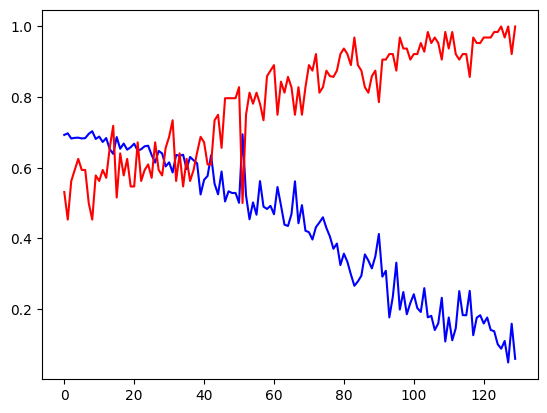

In [54]:
# Gráfica
import matplotlib.pyplot as plt

plt.plot(losses, 'b')
plt.plot(accuracies, 'r')
plt.show()

In [ ]:
import random

def int_to_voc(val, my_dict):
    for word, value in my_dict.items():
        if val==value:
            return word

model.cpu()
review, label = random.choice(train_data)
review_sentence = ' '.join([int_to_voc(val, vocab_to_int) for val in review if val != 0])
print(review_sentence)

print("Actual sentiment:", "negative" if label.item() == 0 else "positive")

h0 = torch.randn(num_layers, 1, hidden_dim)
output = model(review.unsqueeze(0), h0)
sentiment = 'negative' if output < 0.5 else 'positive'
print("Pred. Sentiment:", sentiment)